# Credit Scoring
![](https://www.totaljobs.com/advice/wp-content/uploads/credit-controller-job-description.jpg)

**Задачи проект:**
 - провести EDA
 - создать модель бинарной классификации (Logistic Regression)
 - добавить признаки улучшающие модель 
 - подбор гиперпараметров


**Метрика качества ROC AUC**

1. [Загрузка и первичный просмотр данных](#sec1)
2. [Целевая переменная и пропуски](#sec3)
3. [Визуализация данных](#sec2)
    * [Числовые](#sec2.1)
    * [Бинарные](#sec2.2)
    * [Временные](#sec2.3)
    * [Категориальные](#sec2.4)
4. [Выбросы](#sec4)
5. [Генерация новых признаков](#sec5)
    * [Polynominal features](#sec5.1)
    * [OneHotEncoding](#sec5.2)
6. [Нормализация данных](#sec6)
7. [Проверка значимости признаков](#sec7)
    * [Числовые](#sec7.1)
    * [Категориальные + Бинарные](#sec7.2)
8. [Модель](#sec8)
    * [base](#sec8.1)
    * [l2 grid](#sec8.2)
    * [l1 grid](#sec8.3)
    * [Elastic grid](#sec8.4)
9. [Submit](#sec9)
    



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, QuantileTransformer, PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from gauss_rank_scaler import GaussRankScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score
from mlxtend.plotting import plot_confusion_matrix

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

# data_directory = '/kaggle/input/sf-dst-scoring/'
pd.set_option('display.max_columns', 500) 
sns.set(rc={'figure.figsize': (8, 5)}) 
plt.style.use('seaborn-deep')

<a id="sec1"></a>
## [Загрузка и первичной просмотр данных](#sec1)

**Описания полей**

- **client_id** - идентификатор клиента
- **education** - уровень образования
- **sex** - пол заемщика
- **age** - возраст заемщика
- **car** - флаг наличия автомобиля
- **car_type** - флаг автомобиля иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия “хорошей” работы
- **bki_request_cnt** - количество запросов в БКИ
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заемщика
- **foreign_passport** - наличие загранпаспорта
- **sna** - связь заемщика с клиентами банка
- **first_time** - давность наличия информации о заемщике
- **score_bki** - скоринговый балл по данным из БКИ
- **region_rating** - рейтинг региона
- **app_date** - дата подачи заявки
- **default** - флаг дефолта по кредиту

In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

Посмотрим на наши данные, размер, типы признаков.

In [5]:
print('train:', train.shape)
print('test:', test.shape)

train: (73799, 19)
test: (36349, 18)


In [6]:
print('train:')
display(train.head())
print('test:')
display(test.head())

train:


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


test:


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


<a id="sec3"></a>
## [Целевая переменная и пропуски](#sec3)

In [7]:
info_train = train.agg({'dtype', 'nunique', 'unique'}).T
info_train['miss']= train.isna().sum()
info_test = test.agg({'dtype', 'nunique', 'unique'}).T
info_test['miss']= test.isna().sum()

print('train')
display(info_train)
print('test')
display(info_test)

train


,nunique,unique,dtype,miss
client_id,73799,"[25905, 63161, 25887, 16222, 101655, 41415, 28...",int64,0
app_date,120,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...",object,0
education,5,"[SCH, GRD, UGR, PGR, ACD, nan]",object,307
sex,2,"[M, F]",object,0
age,52,"[62, 59, 25, 53, 48, 27, 39, 50, 54, 29, 32, 3...",int64,0
car,2,"[Y, N]",object,0
car_type,2,"[Y, N]",object,0
decline_app_cnt,21,"[0, 2, 1, 3, 4, 6, 5, 7, 8, 9, 13, 11, 19, 10,...",int64,0
good_work,2,"[0, 1]",int64,0
score_bki,69096,"[-2.00875292, -1.53227621, -1.40814226, -2.057...",float64,0


test


,nunique,unique,dtype,miss
client_id,36349,"[74835, 17527, 75683, 26883, 28862, 99881, 266...",int64,0
app_date,120,"[22MAR2014, 24JAN2014, 23MAR2014, 03FEB2014, 0...",object,0
education,5,"[GRD, SCH, UGR, PGR, nan, ACD]",object,171
sex,2,"[M, F]",object,0
age,51,"[29, 39, 50, 56, 38, 55, 30, 41, 34, 28, 32, 3...",int64,0
car,2,"[Y, N]",object,0
car_type,2,"[Y, N]",object,0
decline_app_cnt,19,"[0, 5, 3, 1, 2, 6, 4, 8, 10, 7, 12, 9, 14, 11,...",int64,0
good_work,2,"[0, 1]",int64,0
score_bki,34287,"[-2.27188367, -1.50499915, -1.69133904, -2.374...",float64,0


Присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. 'app_date' переведем в формат datetime, 'client_id' - удалим.

In [8]:
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)

train.drop('client_id', axis=1, inplace=True)
test.drop('client_id', axis=1, inplace=True)

 Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак поближе:

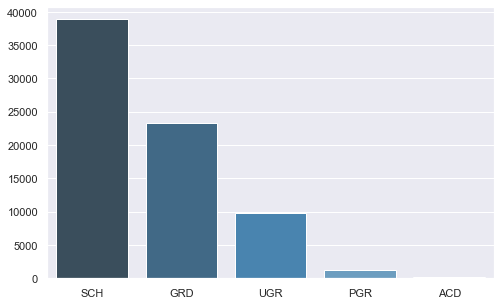

In [9]:
education = train.education.value_counts()
sns.barplot(x=education.index, y= education.values, palette='Blues_r_d');

Заполним пропуски самым частым значением

In [10]:
train.education.fillna(train.education.mode()[0], inplace=True)
test.education.fillna(train.education.mode()[0], inplace=True)
train.education.value_counts(dropna=False).to_frame()

,education
SCH,39167
GRD,23365
UGR,9816
PGR,1257
ACD,194


Посмотрим на распределение целевой переменной

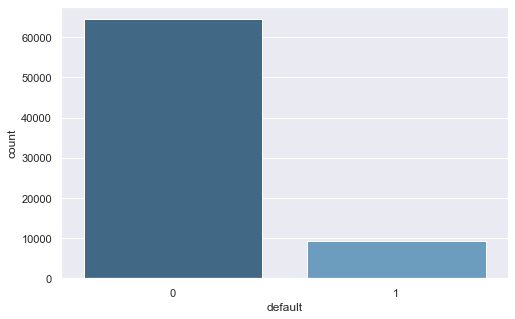

In [11]:
sns.countplot(x='default', data=train, palette='Blues_r_d',);

Целевая переменная несбалансирована, недефолтных клиентов намного больше.

Сгруппирум признаки в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа. 

In [12]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

<a id="sec2"></a>
## [Визуализация данных](#sec2)

<a id="sec2.1"></a>
### [Числовые](#sec2.1)

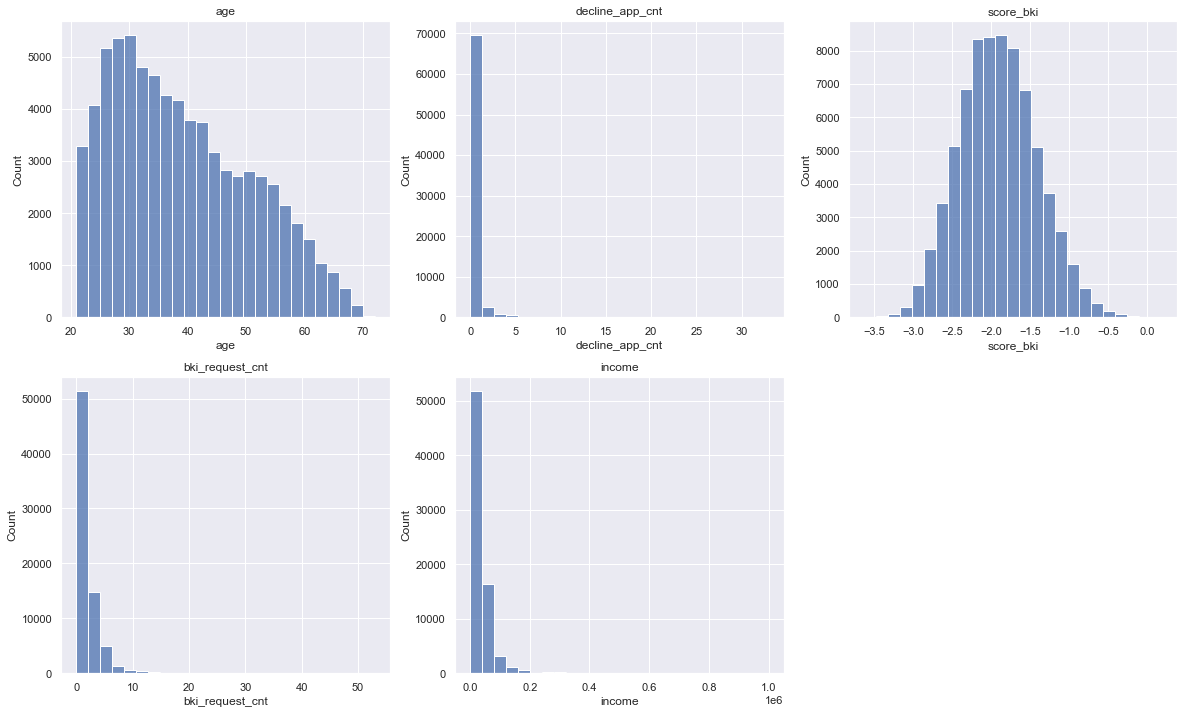

In [13]:
plt.figure(figsize=(20,12))
for i, col in enumerate(num_cols):
    plt.subplot(2,3, i+1)
    sns.histplot(train[col], bins=25, palette='Blues',)
    plt.title(col, fontsize=12)

Только скоринговый бал имеет нормальное распределение, остальные признаки смещены. Построим боксплоты и сравним дефолтных с недефолтными клиентами.

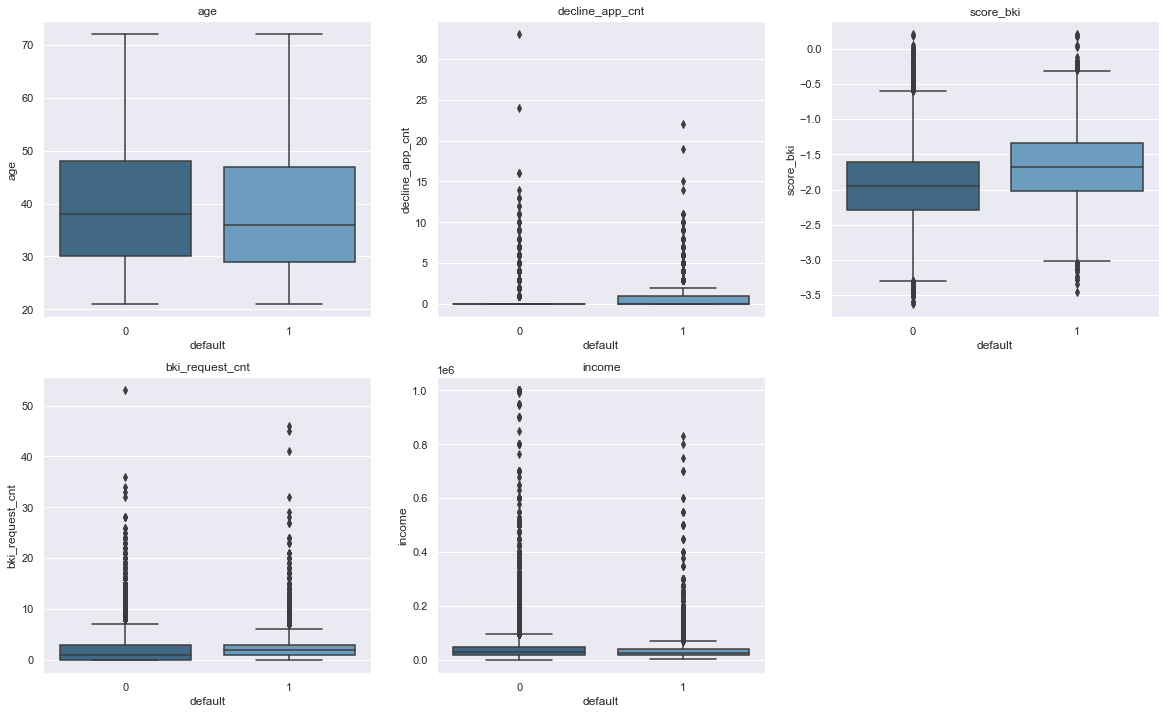

In [14]:
plt.figure(figsize=(20,12))
for i, col in enumerate(num_cols):
    plt.subplot(2,3, i+1)
    sns.boxplot(x='default', y=col, data=train, palette='Blues_r_d',)
    plt.title(col, fontsize=12)

Мы видем много выбросов, недефолтные клиенты немного старше, скоринговый бал БКИ выше у дефолтных клиентов, запросов в БКИ больше у дефолтных клиентов, доход дефолтных клиентов ниже.

<a id="sec2.2"></a>
### [Бинарные](#sec2.2)

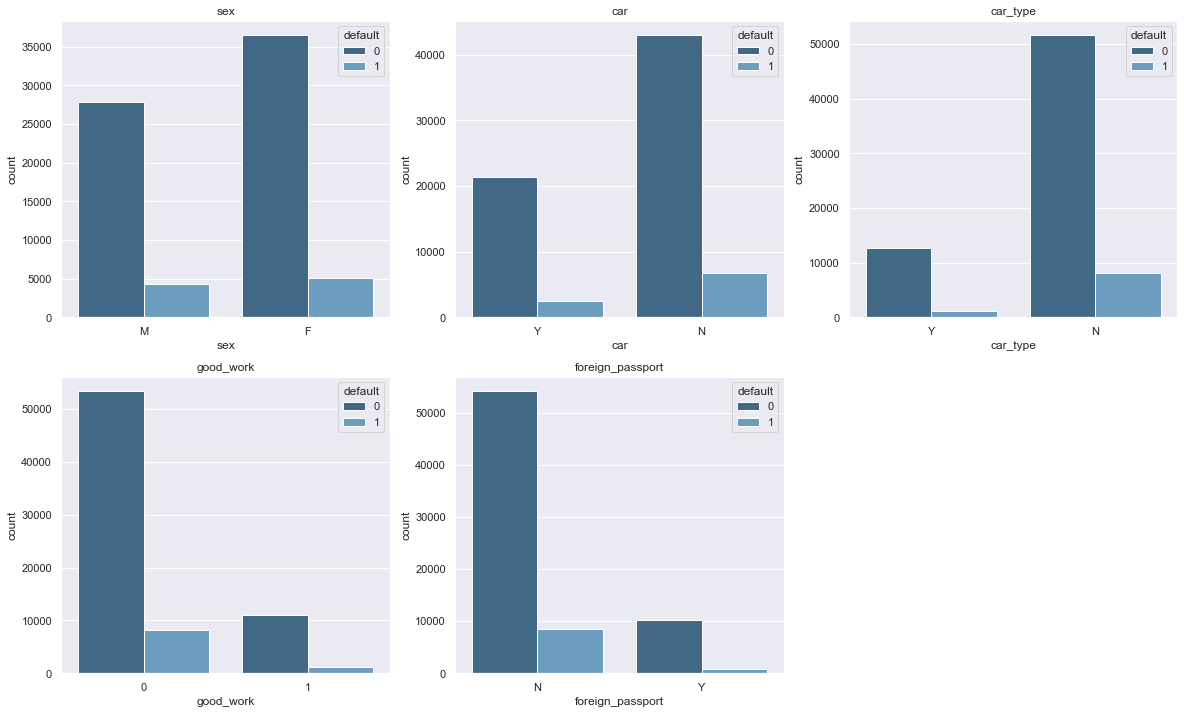

In [15]:
plt.figure(figsize=(20,12))
for i, col in enumerate(bin_cols):
    plt.subplot(2,3, i+1)
    sns.countplot(x=col, data=train, hue='default', palette='Blues_r_d',)
    plt.title(col, fontsize=12)

В данных у нас больше женщин, машину имеют в 2 раза меньше клиентов. Хорошая работа есть у каждого пятого клиента, такое же распределение и по загран паспорту.
Переведем бинарные признаки в числовые.

In [16]:
train.sex = train.sex.map({'M': 1, 'F': 0})
for col in ['car', 'car_type', 'foreign_passport']:
    train[col] = train[col].map({'Y': 1, 'N': 0})

test.sex = test.sex.map({'M': 1, 'F': 0})
for col in ['car', 'car_type', 'foreign_passport']:
    test[col] = test[col].map({'Y': 1, 'N': 0})

<a id="sec2.3"></a>
### [Временные](#sec2.3)

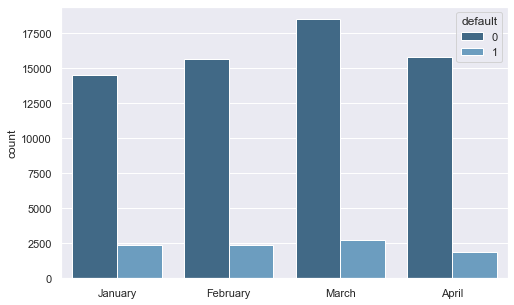

In [17]:
train['day_month'] = train.app_date.dt.month_name()
test['day_month'] = test.app_date.dt.month_name()

sns.countplot(x='day_month', data=train, hue='default', palette='Blues_r_d', 
              order=['January', 'February', 'March', 'April'])
plt.xlabel(None);

Количество заявок больше всего в марте, дефолтов в апреле меньше. 

<a id="sec2.4"></a>
### [Категориальные](#sec2.4)

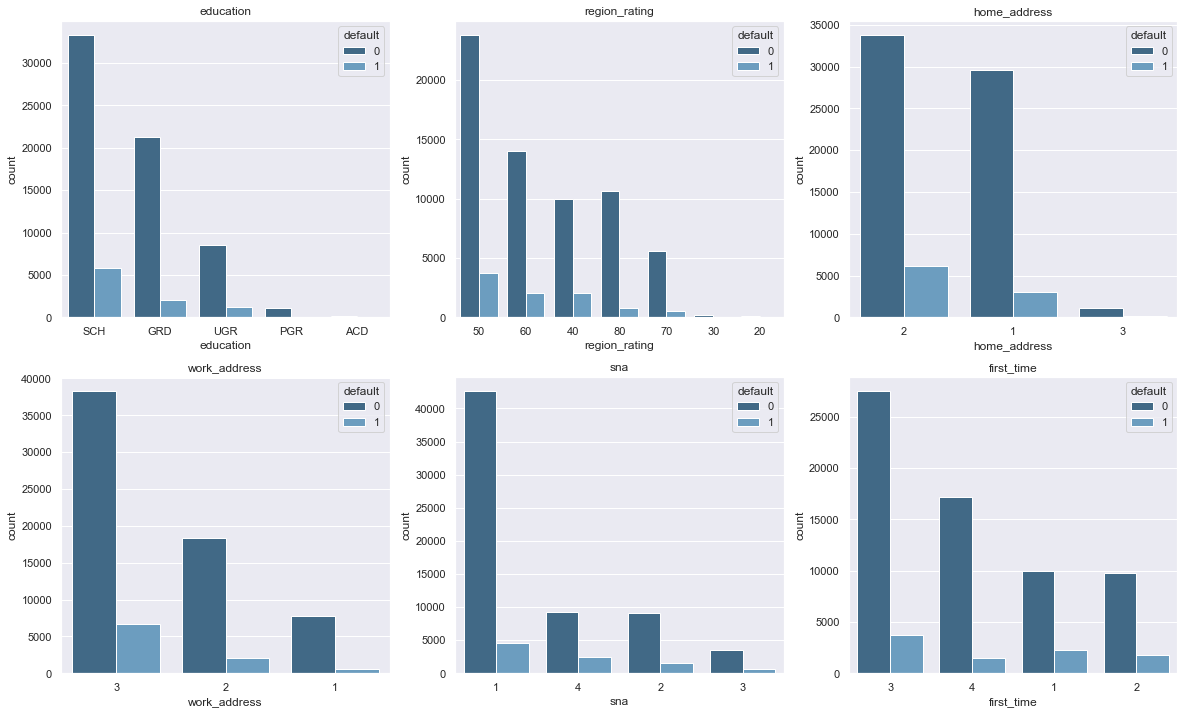

In [18]:
plt.figure(figsize=(20,12))
for i, col in enumerate(cat_cols):
    plt.subplot(2,3, i+1)
    sns.countplot(x=col, data=train, palette='Blues_r_d', order=train[col].value_counts().index, hue='default')
    plt.title(col, fontsize=12)

<a id="sec2.5"></a>
### [Heatmap](#sec2.5)

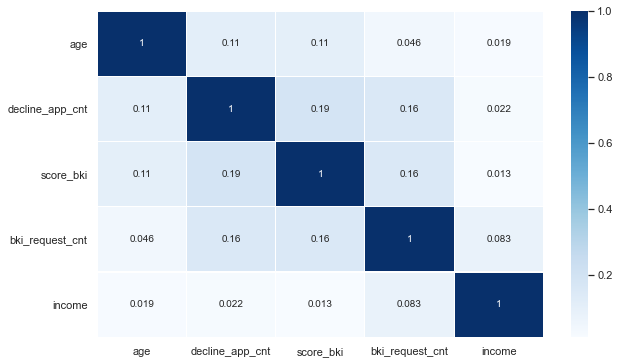

In [19]:
corr = train[num_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr.abs(), annot=True, fmt='.2g', linewidths=0.1, annot_kws={"fontsize":10}, cmap='Blues');

Корреляция невысокая, удалять признаки нет необходимости.

<a id="sec4"></a>
## [Выбросы](#sec4)

In [20]:
def outliers(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    out_b = [q1 - 1.5*iqr, q3 + 1.5*iqr]
    out = len(data[~data[col].between(out_b[0], out_b[1])])
    percent = round((out / len(data[col])) * 100, 2)
    print(col, ':')
    print(f'Количество выбросов: {out}')
    print(f'Процент: {percent}%')
    print(f'Границы выбросов: {out_b}')
    print()
    return out_b

In [21]:
for col in num_cols:
    outliers(train, col)

age :
Количество выбросов: 0
Процент: 0.0%
Границы выбросов: [3.0, 75.0]

decline_app_cnt :
Количество выбросов: 12585
Процент: 17.05%
Границы выбросов: [0.0, 0.0]

score_bki :
Количество выбросов: 351
Процент: 0.48%
Границы выбросов: [-3.2940876975, -0.5352773974999998]

bki_request_cnt :
Количество выбросов: 1755
Процент: 2.38%
Границы выбросов: [-4.5, 7.5]

income :
Количество выбросов: 4695
Процент: 6.36%
Границы выбросов: [-22000.0, 90000.0]



Много выбрасов у decline_app_cnt, очень много значений равных нулю. Перед обучением модели проведем нормализацию, часть выбрасов пропадет.


<a id="sec5"></a>
## [Генерация новых признаков](#sec5)


In [22]:
train['feat1'] = train.income / train.region_rating
test['feat1'] = test.income / test.region_rating

train['feat2'] = train.income / (train.bki_request_cnt + 1)
test['feat2'] = test.income / (test.bki_request_cnt + 1)

train['feat3'] = (train.decline_app_cnt * train.sna) ** 2
test['feat3'] = (test.decline_app_cnt * test.sna) ** 2

train['feat4'] = train.region_rating * train.car
test['feat4'] = test.region_rating * test.car

train['feat5'] = (train.car + train.car_type) / train.sna * train.decline_app_cnt
test['feat5'] = (test.car + test.car_type) / test.sna * test.decline_app_cnt

train['feat6'] = train.first_time * (train.good_work + 1) / train.score_bki
test['feat6'] = test.first_time * (test.good_work + 1) / test.score_bki

train['feat7'] = train.home_address + train.work_address
test['feat7'] = test.home_address + test.work_address

train['feat8'] = train.income**2 / (train.region_rating * (train.decline_app_cnt + 1))
test['feat8'] = test.income**2 / (test.region_rating * (test.decline_app_cnt + 1))

train['feat9'] = train.first_time * train.sna / (train.bki_request_cnt + 1)
test['feat9'] = test.first_time * test.sna / (test.bki_request_cnt +1)

train['feat10'] = (train.score_bki / train.age) ** train.foreign_passport
test['feat10'] = (test.score_bki / test.age) ** test.foreign_passport

train['feat11'] = (train.score_bki / train.age) ** train.sna
test['feat11'] = (test.score_bki / test.age) ** test.sna

mean_income_age = train.groupby('age').income.mean().to_dict()
train['feat12'] = train.age.map(mean_income_age)
test['feat12'] = test.age.map(mean_income_age)

train['feat13'] = train.income - train['feat12']
test['feat13'] = test.income - test['feat12']

train['feat14'] = train.score_bki * train.region_rating / (train.decline_app_cnt + 1)
test['feat14'] = test.score_bki * test.region_rating / (test.decline_app_cnt + 1)

train['feat15'] = train.income * (train.foreign_passport + 1) / train.region_rating
test['feat15'] = test.income * (test.foreign_passport + 1) / test.region_rating

train['feat16'] = (train.sna + train.decline_app_cnt) / train.region_rating
test['feat16'] = (test.sna + test.decline_app_cnt) / test.region_rating

train['feat17'] = train.age / (train.decline_app_cnt + 1)
test['feat17'] = test.age / (test.decline_app_cnt + 1)

train['feat18'] = train.age / train.score_bki
test['feat18'] = test.age / test.score_bki

train['feat19'] = train.good_work * (train.home_address + train.work_address) 
test['feat19'] = test.good_work * (test.home_address + test.work_address) 

train['feat21'] = train.score_bki / train.sna
test['feat21'] = test.score_bki / test.sna

train['feat22'] = (train.home_address + train.work_address) * train.sna 
test['feat22'] = (test.home_address + test.work_address) * test.sna

train['feat23'] = train.decline_app_cnt * train.sna
test['feat23'] = test.decline_app_cnt * test.sna

train['feat24'] = (train.score_bki * train.region_rating / (train.decline_app_cnt + 1)) ** 2
test['feat24'] = (test.score_bki * test.region_rating / (test.decline_app_cnt + 1)) ** 2

In [23]:
# список новых признаков
new_feat = list(train.columns[train.columns.str.contains('feat')])

<a id="sec5.1"></a>
### [Polynomial features](#sec5.1)


In [24]:
poly = PolynomialFeatures(3)
poly_train_values = poly.fit_transform(train[num_cols])[:,7:]
poly_cols = poly.get_feature_names()[7:]
poly_train = pd.DataFrame(columns=poly_cols, data=poly_train_values)

poly = PolynomialFeatures(3)
poly_test_values = poly.fit_transform(test[num_cols])[:,7:]
poly_test = pd.DataFrame(columns=poly_cols, data=poly_test_values)

In [25]:
train = pd.concat([train, poly_train], axis=1)
test = pd.concat([test, poly_test], axis=1)


<a id="sec5.2"></a>
### [OneHotEncoder](#sec5.2)

In [26]:
cat_cols += ['day_month']

df = pd.concat([train, test], axis=0)
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)
train = df[~df.default.isna()]
test = df[df.default.isna()]


<a id="sec6"></a>
## [Нормализация данных](#sec6)

Приведем данные к единому масштабу и нормальному распределению, в этом нам поможет GaussRankScaler.

In [27]:
scaler = GaussRankScaler()
for col in poly_cols:
    train[col] = scaler.fit_transform(train[[col]])
    test[col] = scaler.transform(test[[col]])

In [28]:
for col in new_feat:
    train[col] = scaler.fit_transform(train[[col]])
    test[col] = scaler.transform(test[[col]])

In [29]:
scaler = GaussRankScaler()
for col in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    train[col] = scaler.fit_transform(train[[col]])
    test[col] = scaler.transform(test[[col]])

<a id="sec7"></a>
## [Проверка значимости признаков](#sec7)


<a id="sec7.1"></a>
### [Числовые](#sec7.1)

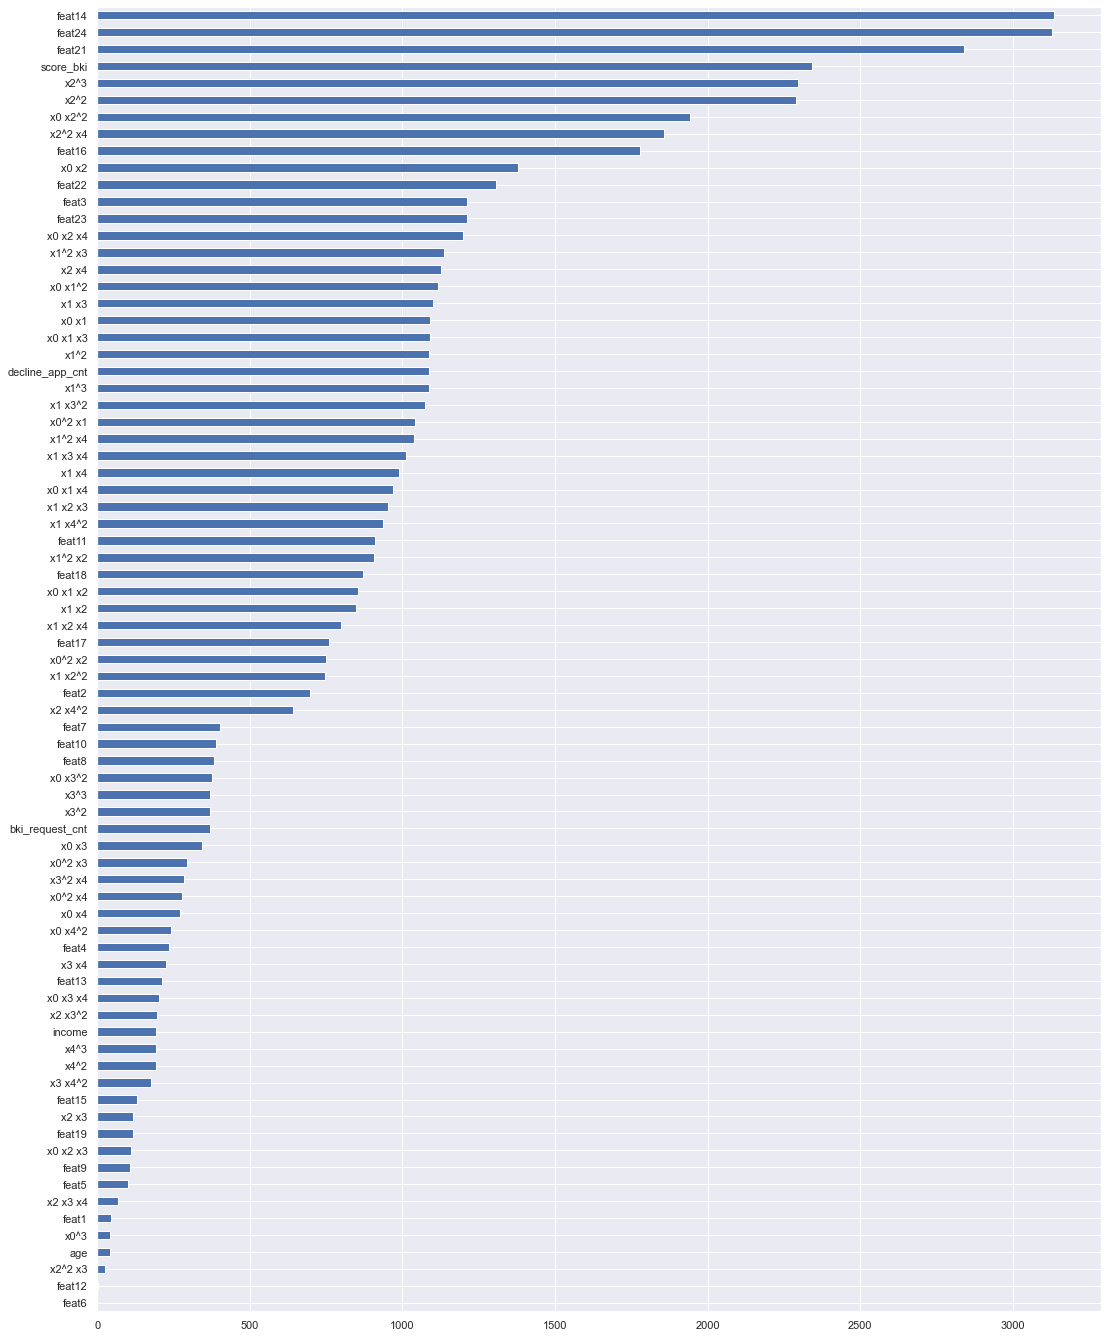

In [30]:
imp_num = pd.Series(f_classif(train[num_cols + new_feat + poly_cols], 
                              train['default'])[0], index=num_cols + new_feat + poly_cols)
imp_num.sort_values(inplace = True)
plt.figure(figsize=(18,24))
imp_num.plot(kind = 'barh');

Из созданных фмчей, есть те, которые сильней влияют на таргет, чем исходные признаки.

In [29]:
train.drop(imp_num[[4,9,11,18,19,28]].index, axis=1, inplace=True)
test.drop(imp_num[[4,9,11,18,19,28]].index, axis=1, inplace=True)

# train.drop(['feat5'], axis=1, inplace=True)
# test.drop(['feat5'], axis=1, inplace=True)

<a id="sec7.2"></a>
### [Категориальные + Бинарные](#sec7.2)

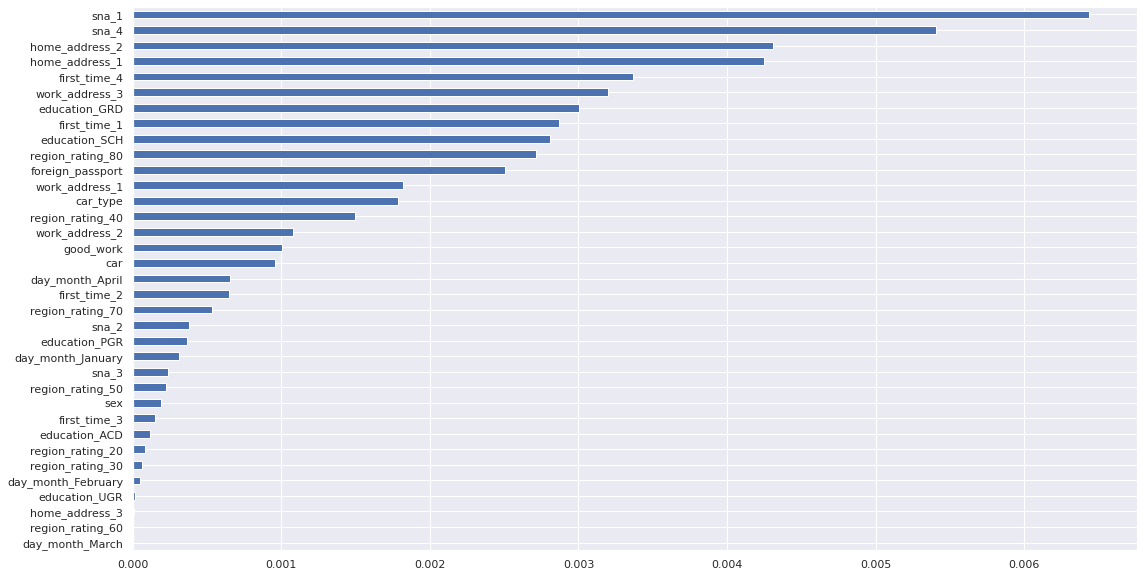

In [30]:
bin_cols = train.nunique()[train.nunique() == 2].drop('default').index

imp_bin = pd.Series(mutual_info_classif(train[bin_cols], train['default'],
                                        discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
plt.figure(figsize=(18,10))
imp_bin.plot(kind = 'barh');

In [31]:
train.drop(imp_bin[[0,1,7,6]].index, axis=1, inplace=True)
test.drop(imp_bin[[0,1,7,6]].index, axis=1, inplace=True)


<a id="sec8"></a>
## [Модель](#sec8)

In [32]:
def metrics(name='model'):
    '''метрики качество модели, confusion_matrix и график roc_auc'''
    fpr, tpr, threshold = roc_curve(y_test, proba)
    roc_auc = roc_auc_score(y_test, proba)
    accuracy = accuracy_score(y_test, predict)
    precision = precision_score(y_test, predict)
    recall = recall_score(y_test, predict)
    f1 = f1_score(y_test, predict)
    conf_matrix = confusion_matrix(y_test, predict)

    metric_df = pd.DataFrame({'accuracy': [accuracy], 'precision': [precision], 
              'recall': [recall], 'f1': [f1], 'roc_auc': [roc_auc]}, index=[name])
    display(metric_df)
    
    class_names=['no default', 'default']
    plot_confusion_matrix(conf_matrix, class_names=class_names, figure=plt.figure())
    plt.xticks(rotation=0)
    plt.yticks(rotation=90)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right');
    return metric_df

Отделим таргет и разобьем выборку на тренировочную и тестовую.

In [33]:
X = train.drop(['default', 'app_date'], axis=1)
y = train.default

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)



<a id="sec8.1"></a>
### [base](#sec8.1)


Начнем с базовой модели, далее попробуем подобрать лучшие гиперпараметры через GridSearchCV отдельно для l1, l2, elasticnet. Перекрестную кроссвалидацию проведем на 4 фолдах.

In [35]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)[:, 1]
predict = clf.predict(X_test)

,accuracy,precision,recall,f1,roc_auc
base,0.869851,0.447619,0.024607,0.04665,0.745296


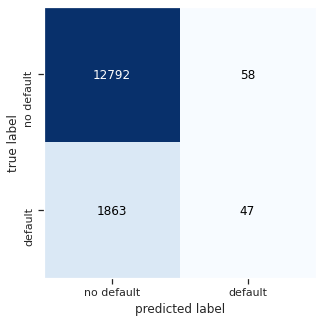

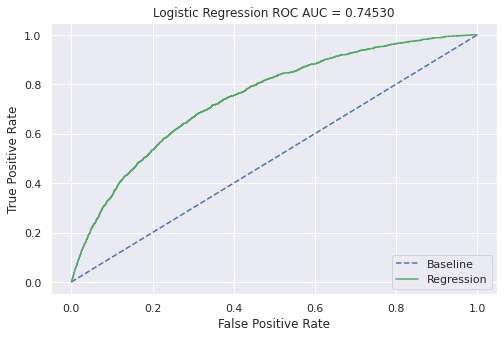

In [36]:
base = metrics('base')

Присутствует ошибка первого рода, модель не угадывает дефолтных клиентов. Причина не сбаласированый таргет, учтем class_weight="balanced".

<a id="sec8.2"></a>
### [l2 grid](#sec8.2)

In [37]:
param = {'penalty': ['l2'],
         'C': np.logspace(-2, 2, 10),
         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
         'max_iter': [100]}

clf = LogisticRegression(class_weight="balanced")
gs = GridSearchCV(clf, param_grid=param,  cv=4, scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)
proba = gs.predict_proba(X_test)[:, 1]
predict = gs.predict(X_test)
gs.best_params_

{'C': 0.5994842503189409, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}

,accuracy,precision,recall,f1,roc_auc
l2,0.672154,0.238529,0.699476,0.355745,0.746676


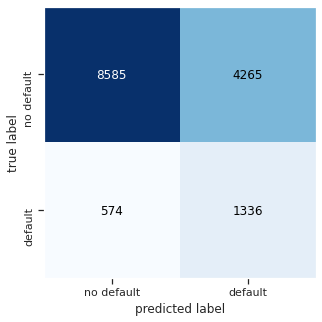

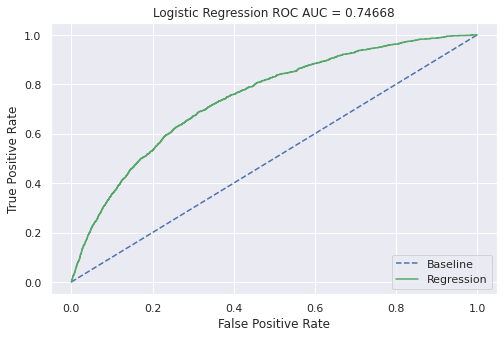

In [38]:
l2 = metrics('l2')


<a id="sec8.3"></a>
### [l1 grid](#sec8.3)


In [39]:
param = {'penalty': ['l1'],
         'C': np.logspace(-2, 2, 10),
         'solver': ['saga'],
         'max_iter': [100]}

clf = LogisticRegression(class_weight="balanced")
gs = GridSearchCV(clf, param_grid=param,  cv=4, scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)
proba = gs.predict_proba(X_test)[:, 1]
predict = gs.predict(X_test)
gs.best_params_

{'C': 1.6681005372000592, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

,accuracy,precision,recall,f1,roc_auc
l1,0.672019,0.238444,0.699476,0.35565,0.746705


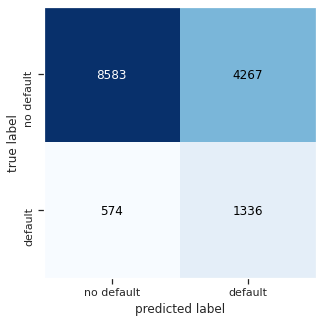

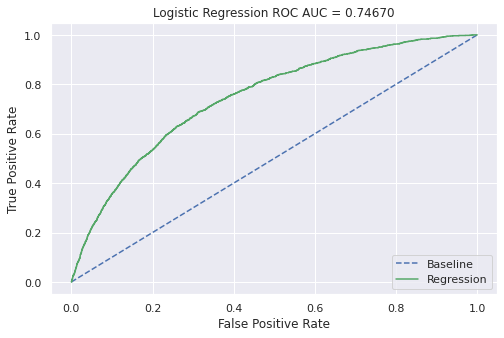

In [40]:
l1 = metrics('l1')

<a id="sec8.4"></a>
### [Elastic grid](#sec8.4)

In [41]:
param = {'penalty': ['elasticnet'],
         'l1_ratio': np.linspace(0,1,10),
         'solver': ['saga'],
         'max_iter': [100]}

clf = LogisticRegression(class_weight="balanced")
gs = GridSearchCV(clf, param_grid=param,  cv=4, scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)
proba = gs.predict_proba(X_test)[:, 1]
predict = gs.predict(X_test)
gs.best_params_

{'l1_ratio': 0.0, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}

,accuracy,precision,recall,f1,roc_auc
elasticnet,0.672154,0.238435,0.698953,0.355573,0.746717


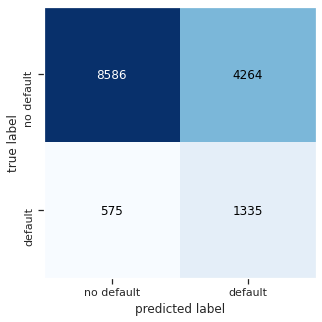

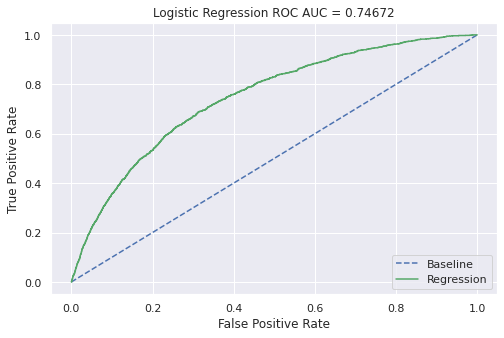

In [42]:
elasticnet = metrics('elasticnet')

### Резюмируем

In [43]:
table_metric = pd.concat([base, l2, l1, elasticnet])
table_metric.style.highlight_max(color='lightgreen')

,accuracy,precision,recall,f1,roc_auc
base,0.869851,0.447619,0.024607,0.046650,0.745296
l2,0.672154,0.238529,0.699476,0.355745,0.746676
l1,0.672019,0.238444,0.699476,0.355650,0.746705
elasticnet,0.672154,0.238435,0.698953,0.355573,0.746717


Данные несбалансированые, метрика accuracy не подходит к нашей задачи. Мы перебрали гиперпараметры и основываясь на метриках f1 и roc_auc, настроим модель и сделаем сабмит. 

<a id="sec9"></a>
## [Submit](#sec9)


In [44]:
clf = LogisticRegression(class_weight="balanced", max_iter=1000, C=0.5994842503189409, penalty='l2', solver='liblinear')
clf = clf.fit(X_train, y_train)

In [45]:
test = test.drop(['default', 'app_date'], axis=1)
test.fillna(0, inplace=True)
X_test = test
proba = clf.predict_proba(X_test)[:, 1]
submit = pd.read_csv('../input/sf-dst-scoring/test.csv').client_id.to_frame()
submit['default'] = proba
submit.to_csv('submission.csv', index=False)
submit

,client_id,default
0,74835,0.216242
1,17527,0.715757
2,75683,0.353692
3,26883,0.377171
4,28862,0.113695
...,...,...
36344,83775,0.812491
36345,106254,0.136942
36346,81852,0.763448
36347,1971,0.677316
